Install Libraries

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, accuracy_score, median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import RFECV
import pickle
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Load Dataset

In [91]:
generalStats_pos = pd.read_csv('E:/Inzynierka/generalStats_pos - generalStats_pos.csv')

Data cleaning

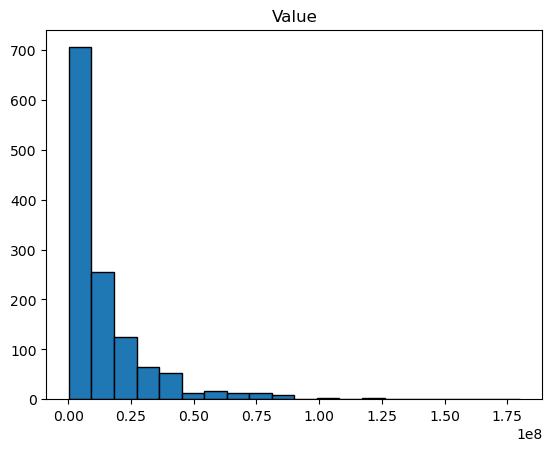

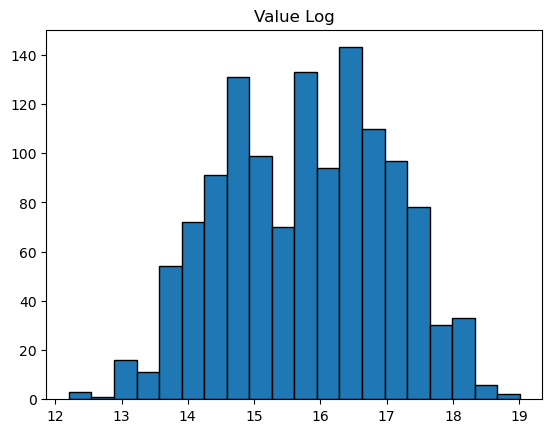

In [92]:
generalStats_pos['value_log'] = generalStats_pos['value'].apply(lambda x: math.log(x))
generalStats_pos = generalStats_pos.dropna()
sorted_data = np.sort(generalStats_pos['value'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value')
plt.show()

sorted_data = np.sort(generalStats_pos['value_log'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value Log')
plt.show()

In [93]:
X = generalStats_pos.iloc[:, 3:-2]
y = generalStats_pos.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [94]:
def calculate_revised_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    msle = mean_squared_log_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2,
        "MAPE": mape,
        "MSLE": msle,
        "Median AE": median_ae
    }

In [95]:
model = RandomForestRegressor()
model.fit(X_train,y_train)
score = model.score(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Score: ', score)

Score:  0.947248024985192


<class 'pandas.core.series.Series'>
0       0.43
1       0.95
2       0.32
3       0.60
4       0.40
        ... 
1310   -0.25
1311   -1.47
1314   -2.25
1315   -0.52
1316   -0.90
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      62736219.67
1      91904155.69
2      32684460.28
3      54202157.76
4      36040008.26
           ...    
1310    -112815.56
1311   -1003863.13
1314   -1699134.51
1315    -136157.58
1316    -292602.23
Name: diff, Length: 1274, dtype: float64
                         Player      value  estimated_value        diff  \
1               Vinicius Júnior  150000000      58095844.31 91904155.69   
5                         Pedri  100000000      32301566.79 67698433.21   
0                Erling Haaland  180000000     117263780.33 62736219.67   
34                 Éder Militão   70000000      15208926.82 54791073.18   
3                Victor Osimhen  120000000      65797842.24 54202157.76   
16          Aurélien Tchouaméni   850000

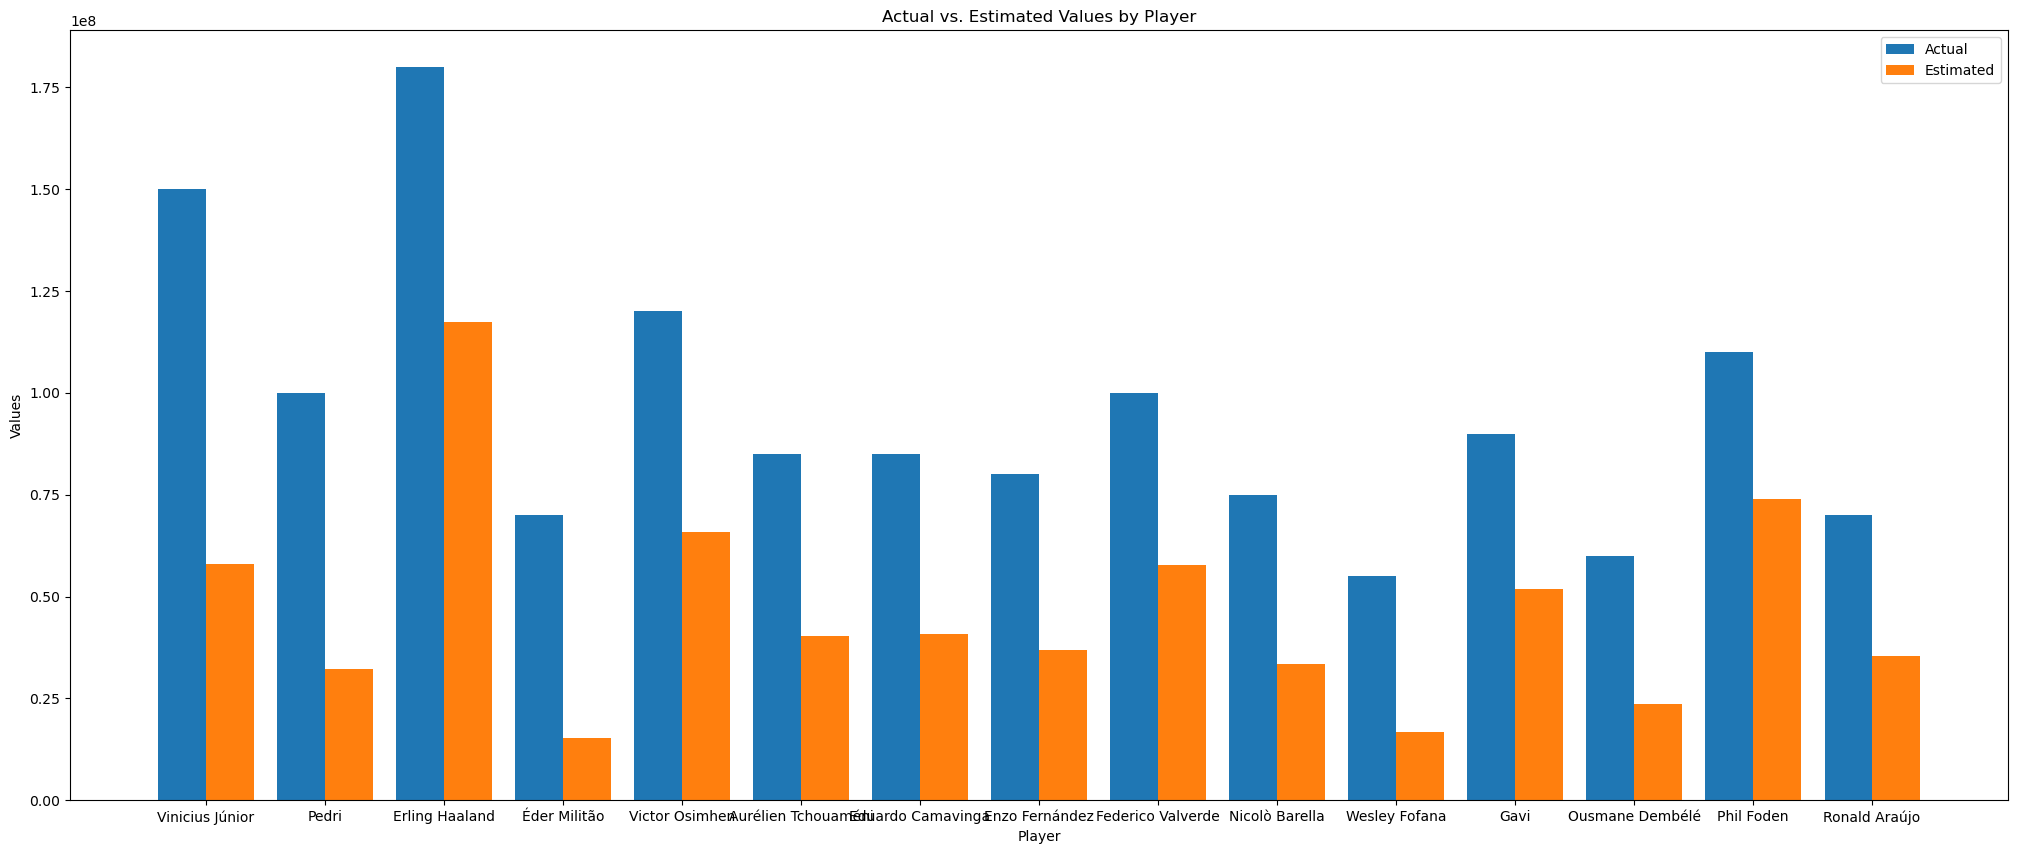

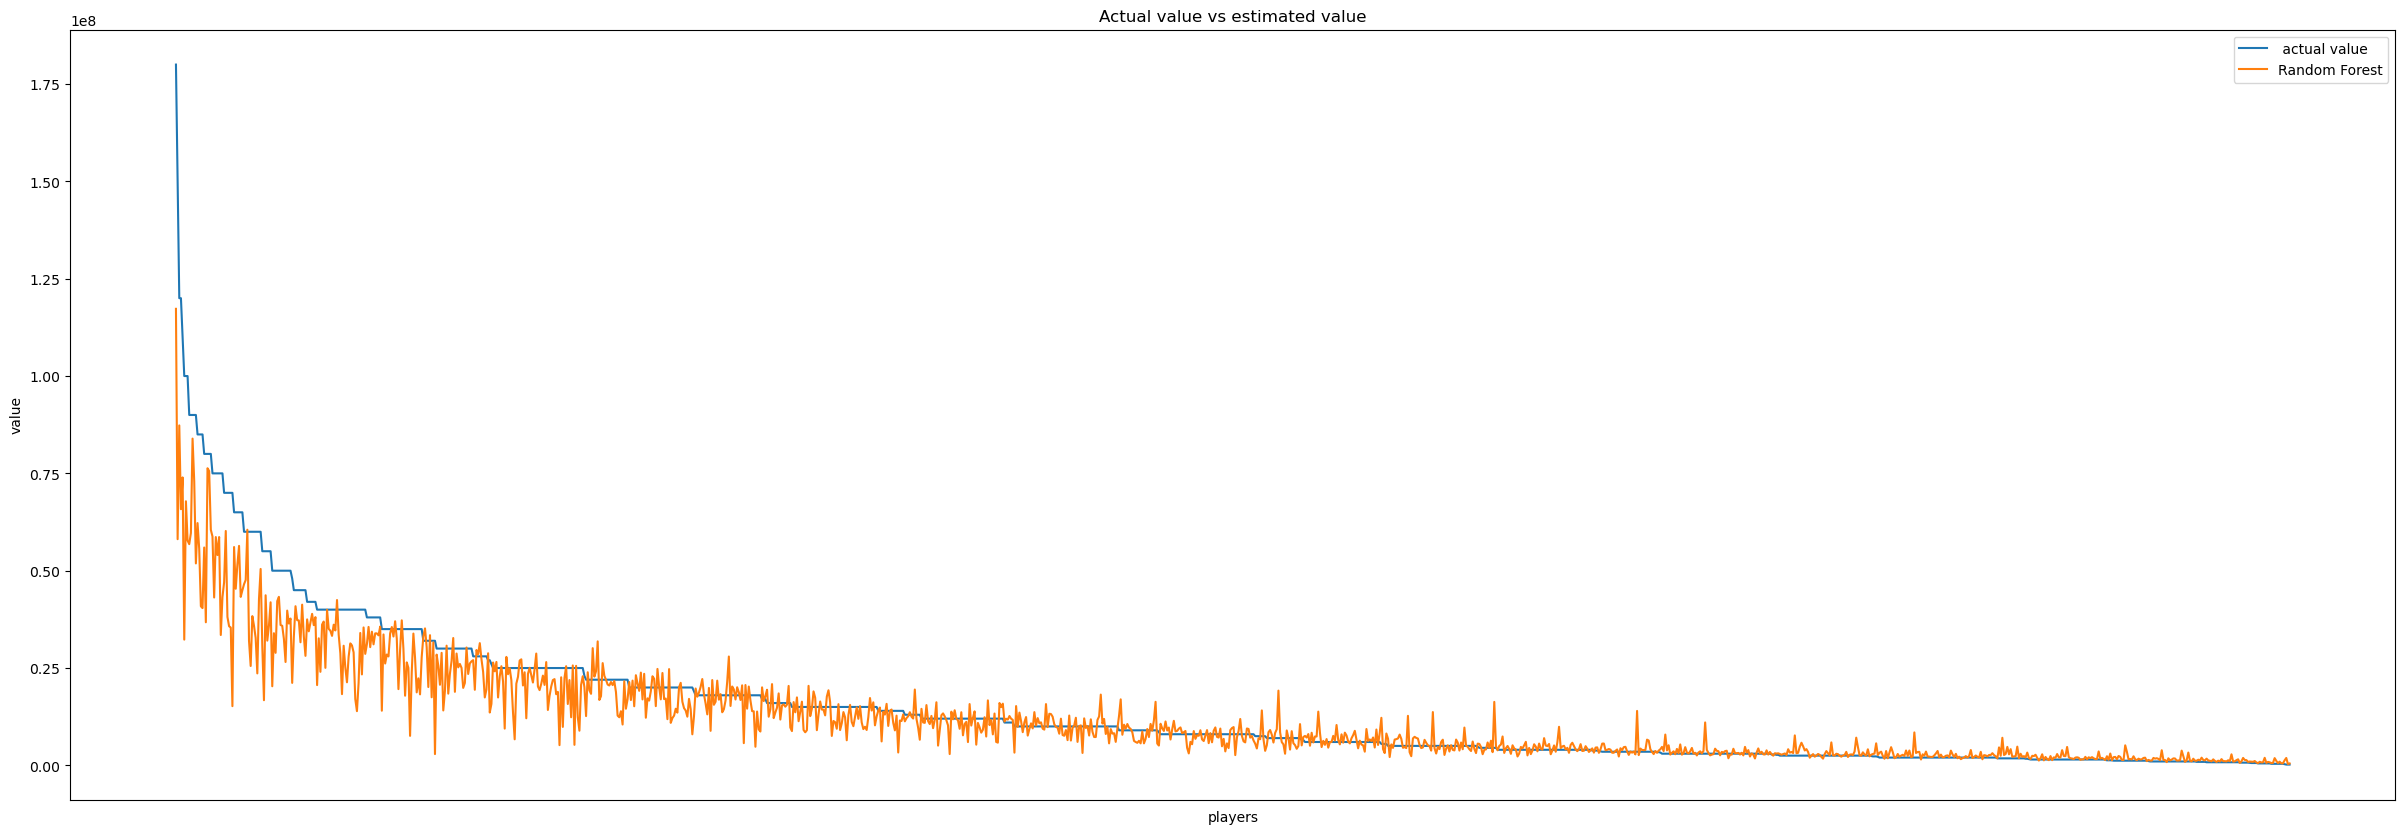

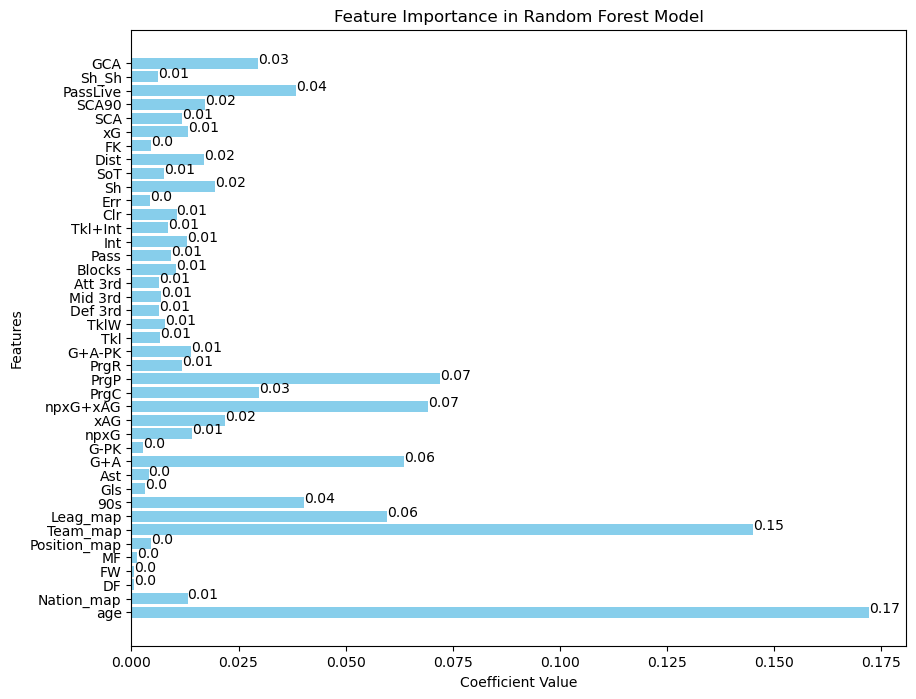

In [96]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos)):
    player_data = generalStats_pos.iloc[i,:].to_frame().transpose()
    player_data = (player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='Random Forest')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = generalStats_pos.iloc[:, 3:-2].columns.tolist()

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Random Forest Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [97]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.5593689419442124, 'MSE': 0.49520704566765694, 'RMSE': 0.7037094895392962, 'R^2': 0.6866728324990206, 'MAPE': 3.625393568983636, 'MSLE': 0.0018507871609470836, 'Median AE': 0.49142237526350385}


RFE on Random forest

In [98]:
"""%%capture


estimator = RandomForestRegressor()
selector = RFECV(estimator, cv=5)
selector = selector.fit(X_train, y_train)

print("Suggested number of features: %d" % selector.n_features_)
print("Selected features: %s" % selector.support_)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

"""

'%%capture\n\n\nestimator = RandomForestRegressor()\nselector = RFECV(estimator, cv=5)\nselector = selector.fit(X_train, y_train)\n\nprint("Suggested number of features: %d" % selector.n_features_)\nprint("Selected features: %s" % selector.support_)\nX_train_selected = selector.transform(X_train)\nX_test_selected = selector.transform(X_test)\n\n'

Which features performs the best

In [99]:
""""
selected_fetures = []
keys = generalStats_pos.iloc[:, 3:-2].keys()
for i in range(0,len(selector.support_)-1):
    if selector.support_[i] == True:
        selected_fetures.append(keys[i])
print(selected_fetures)
print(X_train_selected)
"""

'"\nselected_fetures = []\nkeys = generalStats_pos.iloc[:, 3:-2].keys()\nfor i in range(0,len(selector.support_)-1):\n    if selector.support_[i] == True:\n        selected_fetures.append(keys[i])\nprint(selected_fetures)\nprint(X_train_selected)\n'

Fit the model 

In [100]:
selected_fetures = ['age', 'Team_map', '90s', 'G+A', 'npxG+xAG', 'PrgP', 'PassLive']
X_train_selected = X_train[selected_fetures]
X_test_selected =X_test[selected_fetures]

model = RandomForestRegressor()
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

Score:  0.9508914554294857


<class 'pandas.core.series.Series'>
0       0.39
1       0.84
2       0.17
3       0.62
4       0.38
        ... 
1310   -0.24
1311   -1.60
1314   -2.12
1315   -0.58
1316   -0.73
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      57829526.41
1      84944638.19
2      19160127.63
3      55590344.41
4      34969714.05
           ...    
1310    -108282.47
1311   -1191868.80
1314   -1457959.08
1315    -158169.60
1316    -214275.60
Name: diff, Length: 1274, dtype: float64
                         Player      value  estimated_value        diff  \
1               Vinicius Júnior  150000000      65055361.81 84944638.19   
5                         Pedri  100000000      34558452.50 65441547.50   
34                 Éder Militão   70000000      10603145.18 59396854.82   
0                Erling Haaland  180000000     122170473.59 57829526.41   
3                Victor Osimhen  120000000      64409655.59 55590344.41   
15            Eduardo Camavinga   850000

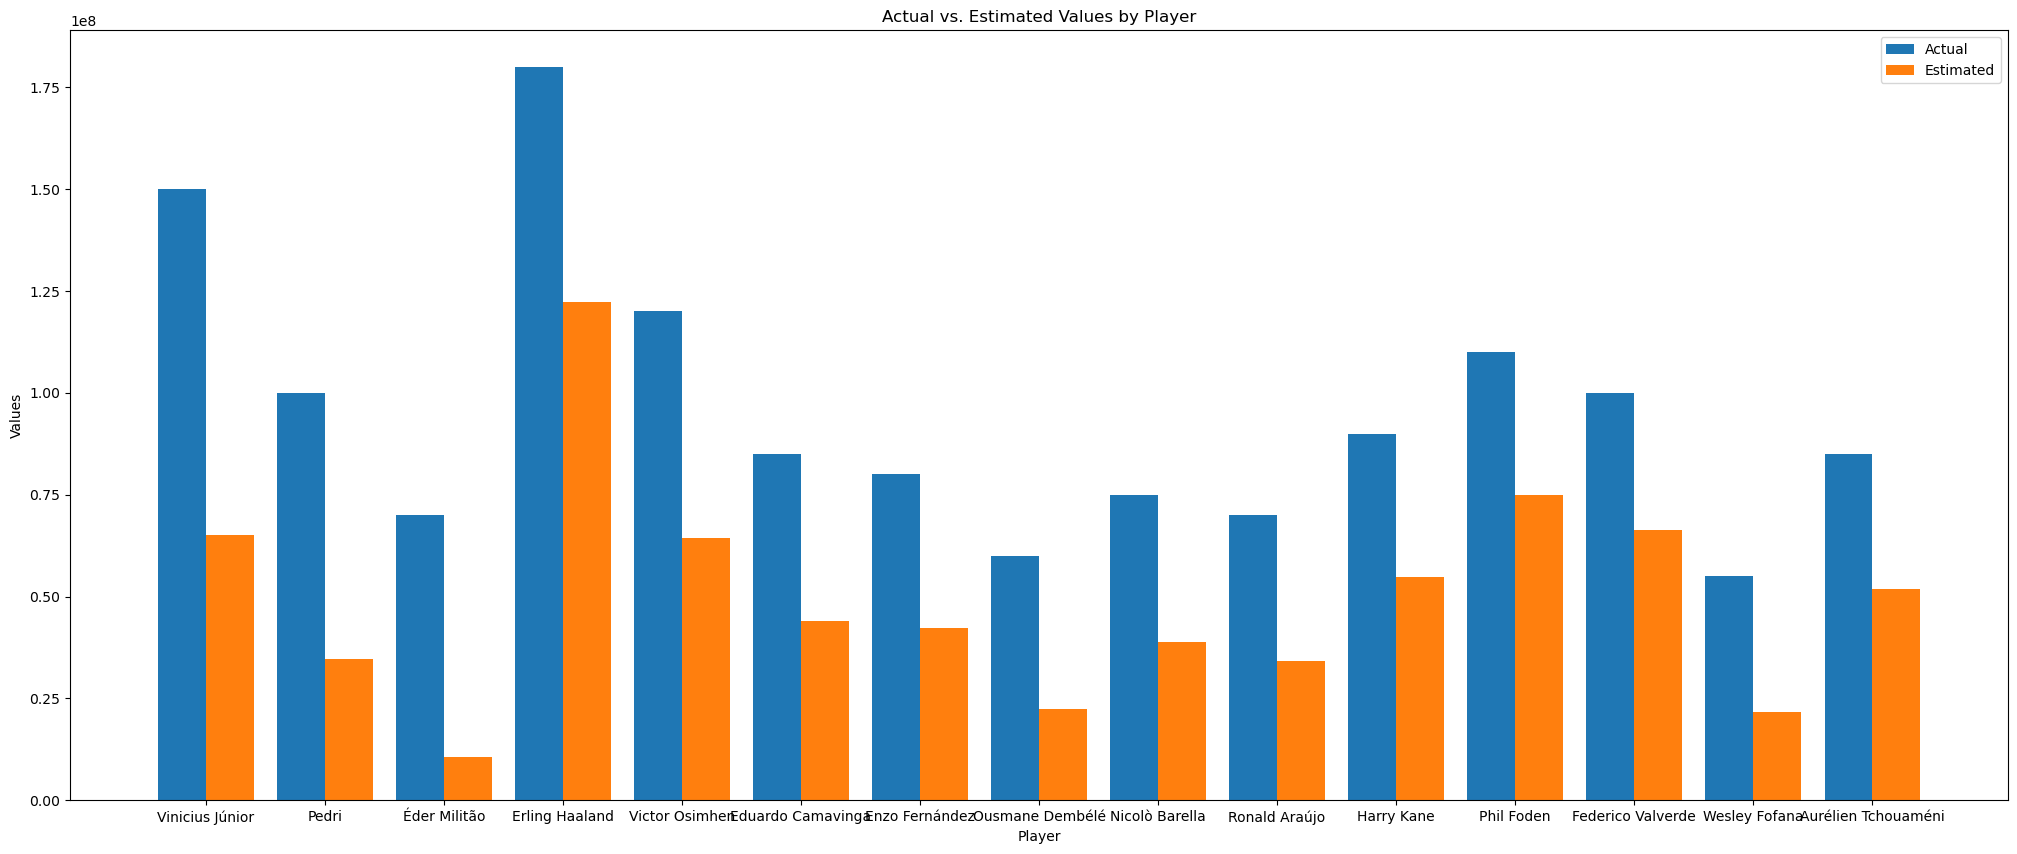

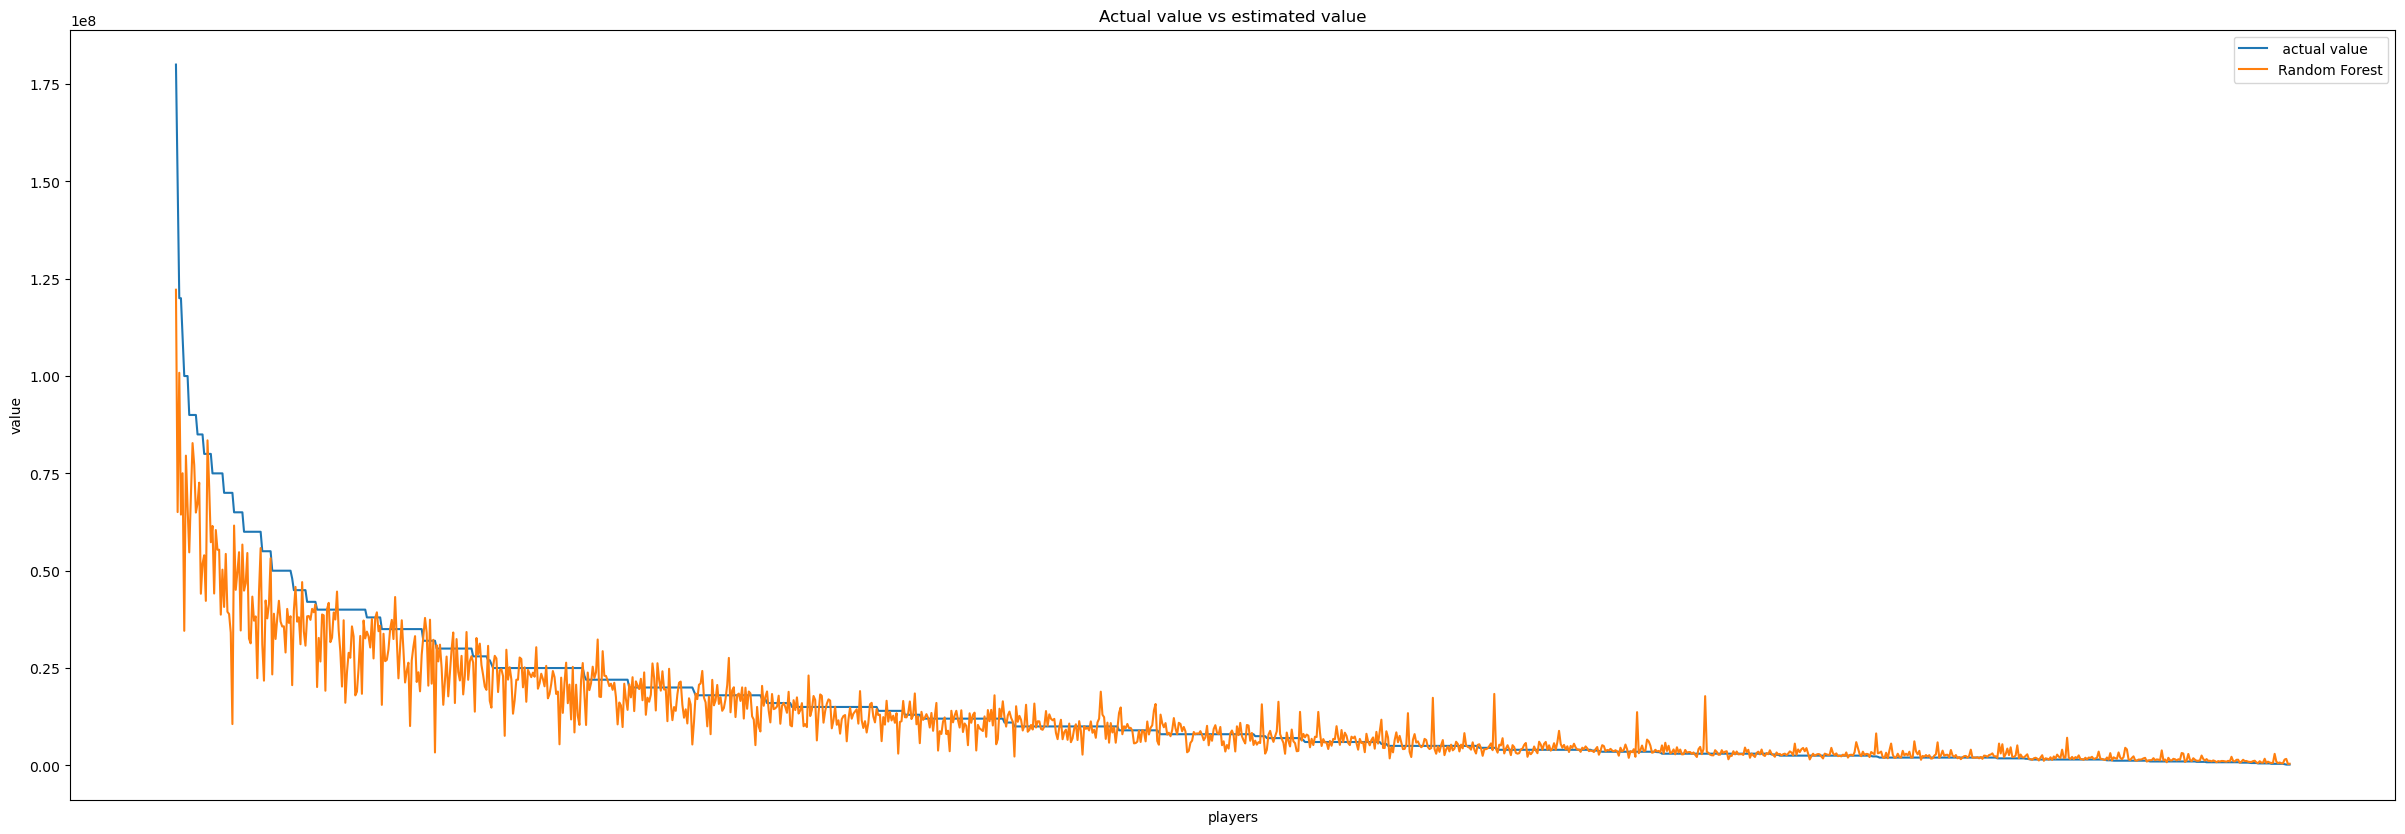

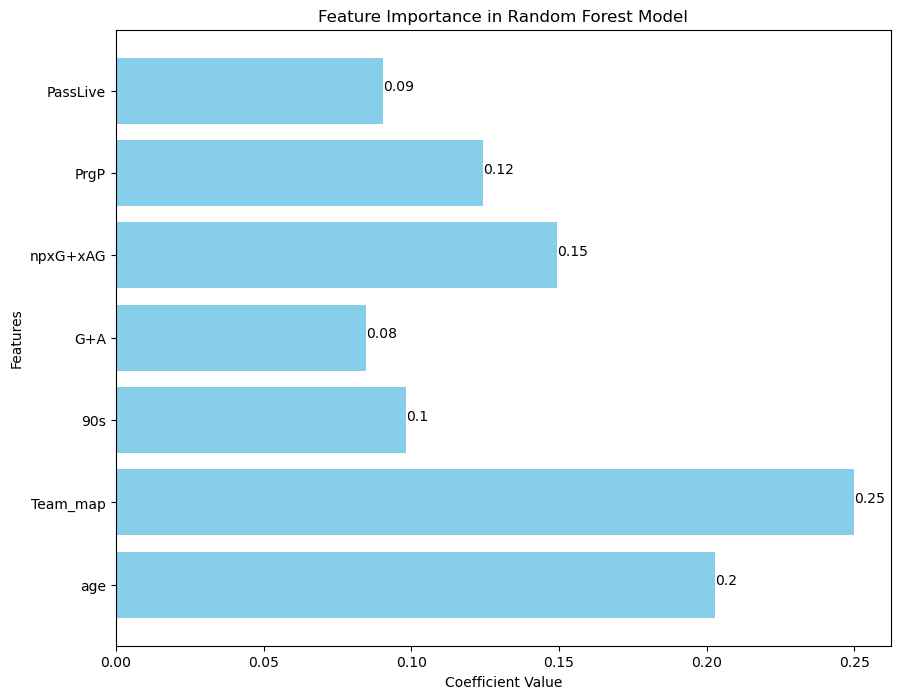

In [101]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = player_data[selected_fetures]
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='Random Forest')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Random Forest Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [102]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.5495557426016499, 'MSE': 0.4866590409041277, 'RMSE': 0.697609518931707, 'R^2': 0.6920813220263262, 'MAPE': 3.567419083187373, 'MSLE': 0.0018254077037191106, 'Median AE': 0.448488304400799}


Perform Hyperparameter tuning by fitting the grid of parameters to the Random Forest and looking for the best combination of features

In [103]:
"""%%capture
param_grid = {'max_depth': [None, 2,4,6,8,10,12],
         'min_samples_split': [2,3,4,5,6,7,8,9,10],
         'min_samples_leaf': [1,2],
         'n_estimators': [100, 200, 300]}

clf = RandomForestRegressor()
gcv = GridSearchCV(estimator=clf,param_grid=param_grid, cv = 5)
gcv.fit(X_train_selected,y_train)
print(best_params = gcv.best_params_)"""

"%%capture\nparam_grid = {'max_depth': [None, 2,4,6,8,10,12],\n         'min_samples_split': [2,3,4,5,6,7,8,9,10],\n         'min_samples_leaf': [1,2],\n         'n_estimators': [100, 200, 300]}\n\nclf = RandomForestRegressor()\ngcv = GridSearchCV(estimator=clf,param_grid=param_grid, cv = 5)\ngcv.fit(X_train_selected,y_train)\nprint(best_params = gcv.best_params_)"

In [104]:
best_params = {'max_depth': 12,'min_samples_split':10,'min_samples_leaf':1, 'n_estimators':200}
model = RandomForestRegressor(**best_params)
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

Score:  0.8726960438868526


Evaluate model after hyperparameter tuning

<class 'pandas.core.series.Series'>
0       0.87
1       0.88
2       0.40
3       0.77
4       0.56
        ... 
1310   -0.45
1311   -1.68
1314   -2.09
1315   -0.88
1316   -1.44
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      104266439.51
1       87748555.23
2       39630419.04
3       64671540.95
4       47047987.53
           ...     
1310     -226864.31
1311    -1317728.54
1314    -1420782.04
1315     -282916.54
1316     -640447.89
Name: diff, Length: 1274, dtype: float64
                    Player      value  estimated_value         diff  \
0           Erling Haaland  180000000      75733560.49 104266439.51   
1          Vinicius Júnior  150000000      62251444.77  87748555.23   
3           Victor Osimhen  120000000      55328459.05  64671540.95   
5                    Pedri  100000000      35863603.41  64136396.59   
34            Éder Militão   70000000      10417316.13  59582683.87   
16     Aurélien Tchouaméni   85000000      26795177.4

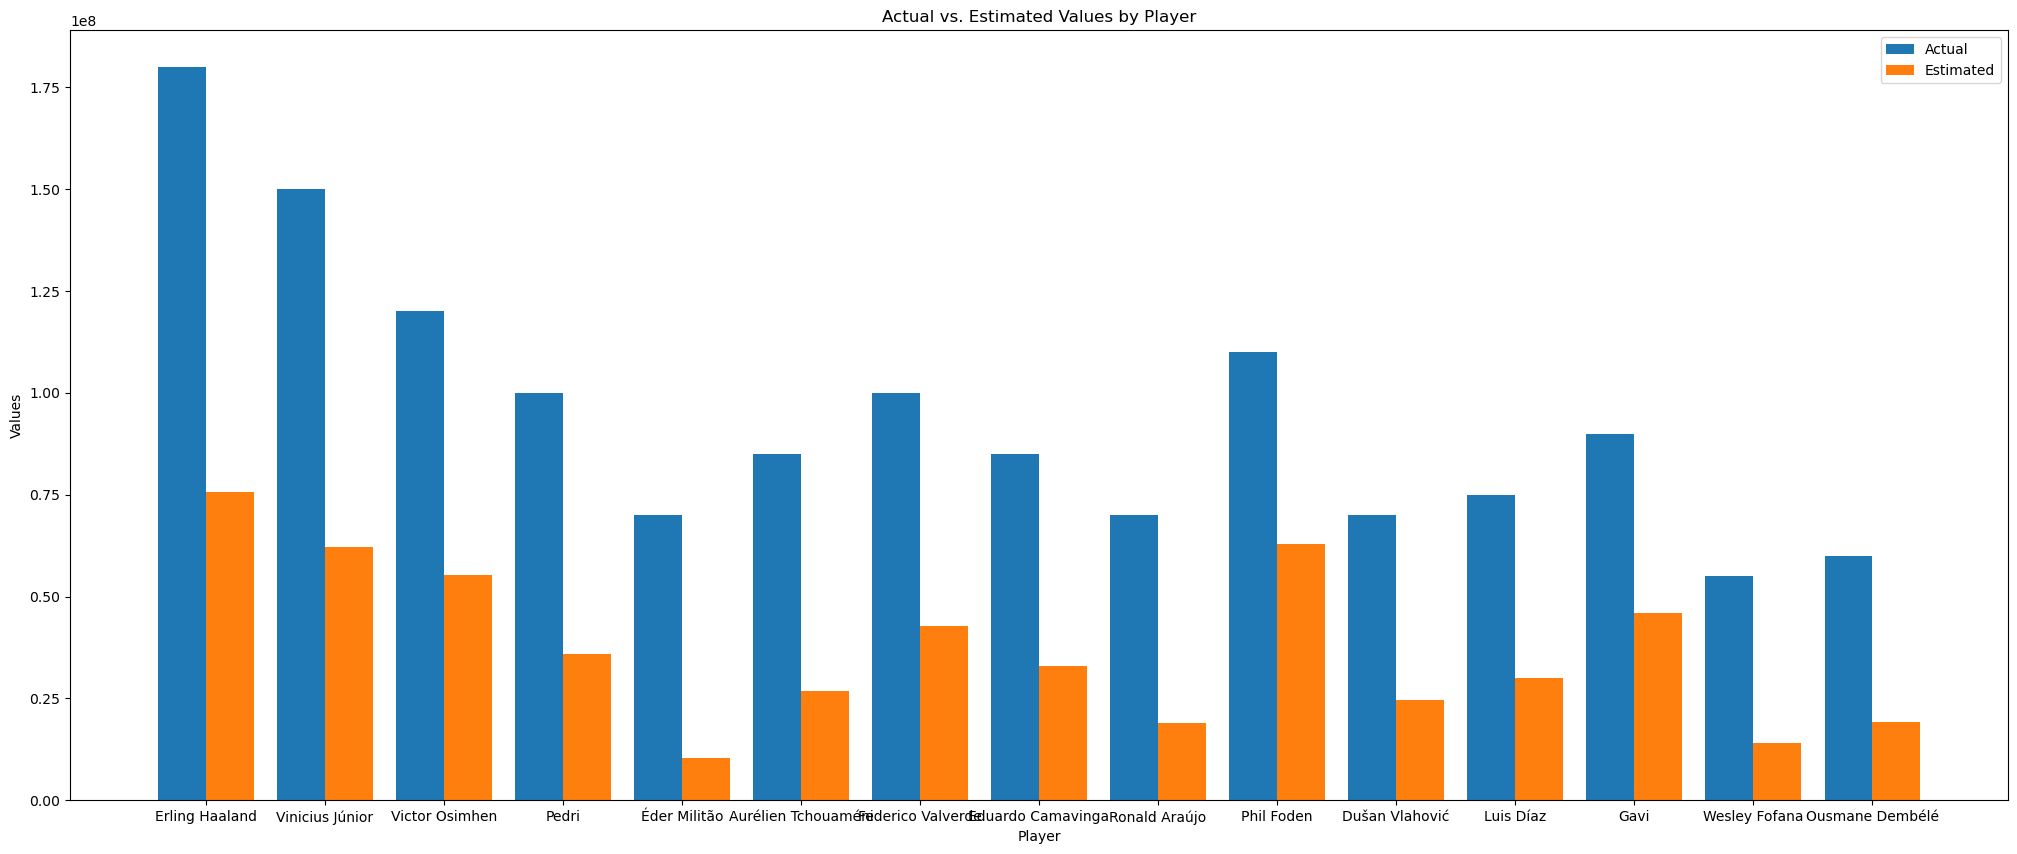

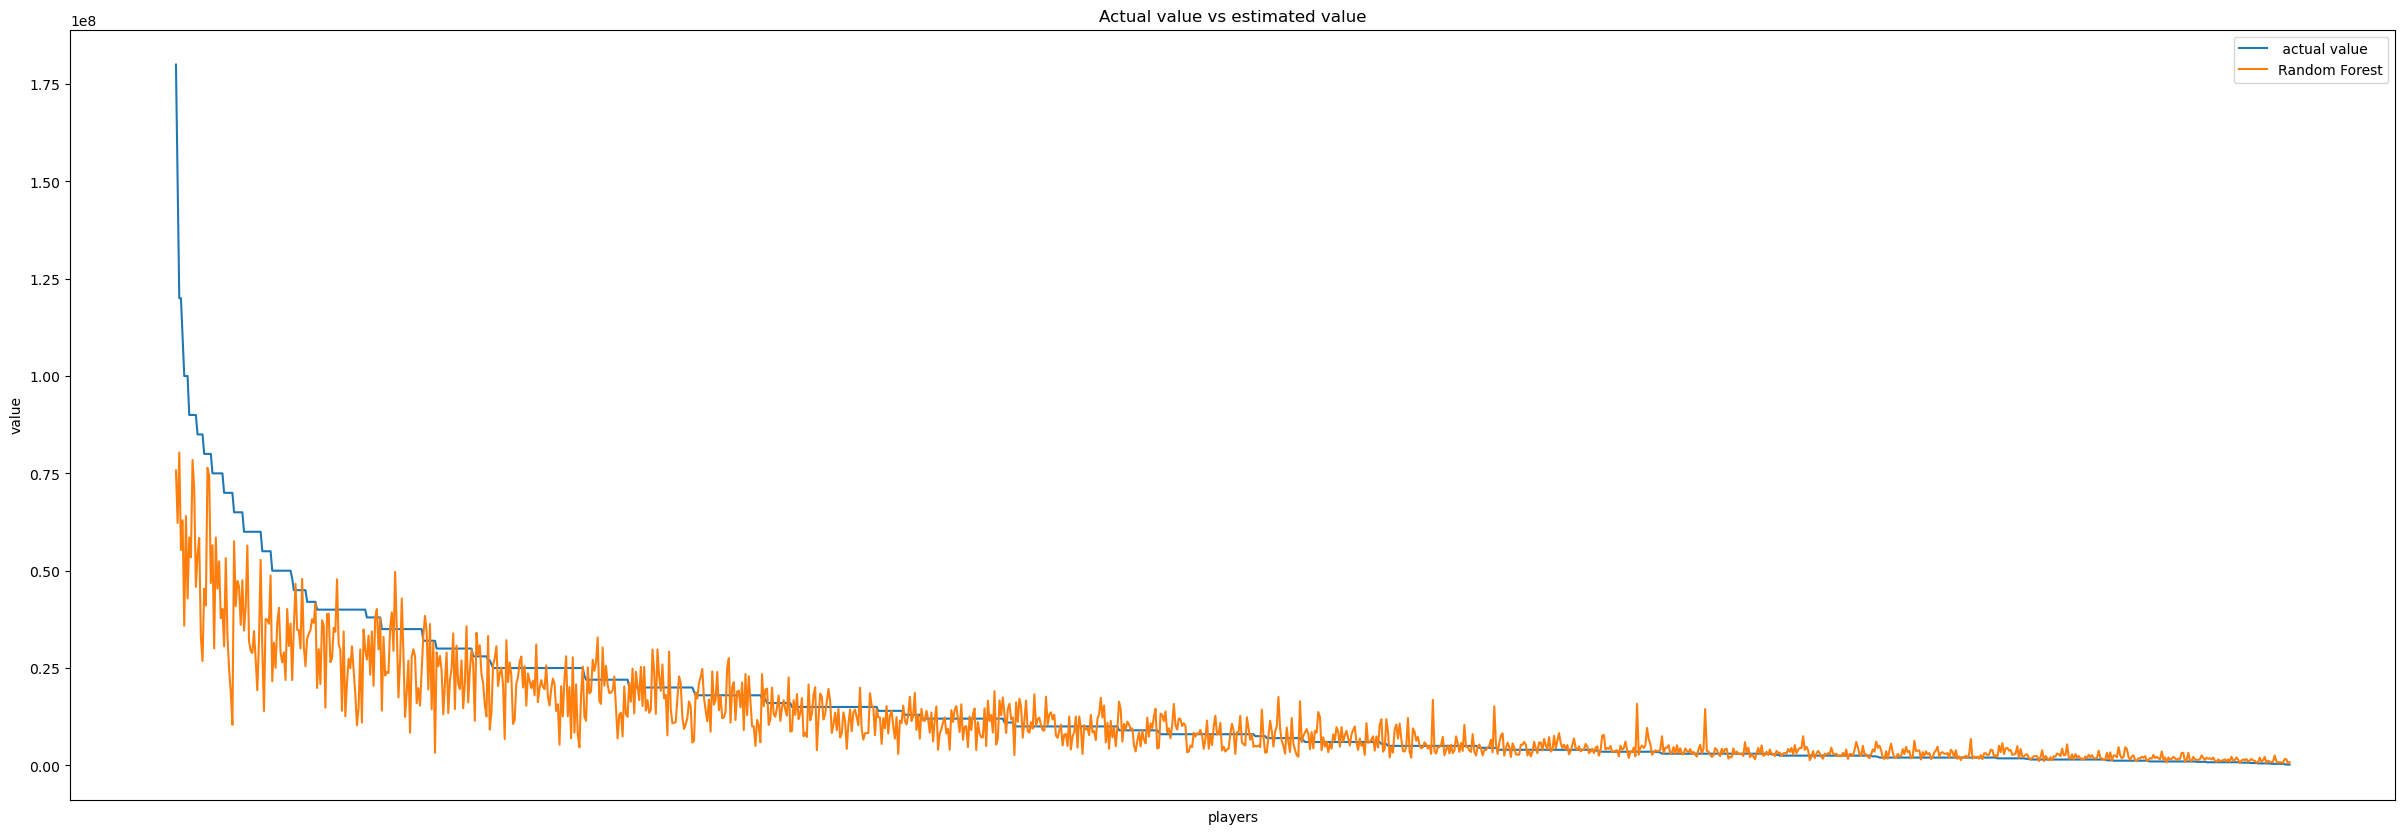

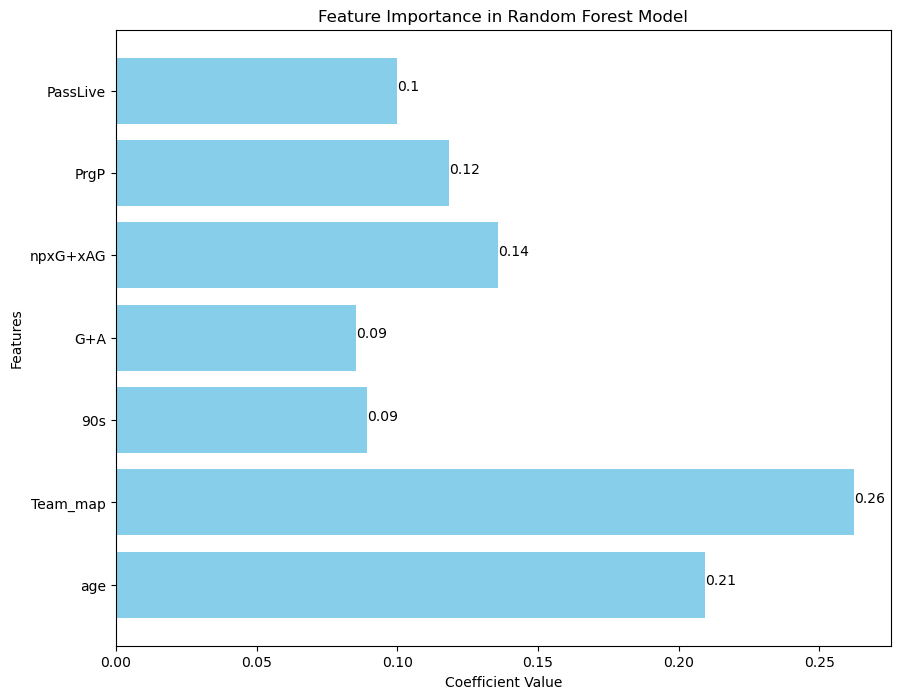

In [105]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = player_data[selected_fetures]
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='Random Forest')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Random Forest Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [106]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)
print(best_params)

{'MAE': 0.5558803048085267, 'MSE': 0.4944474784933832, 'RMSE': 0.7031695944033581, 'R^2': 0.6871534254819436, 'MAPE': 3.6085743057536193, 'MSLE': 0.0018567375581122797, 'Median AE': 0.4813493979564534}
{'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1, 'n_estimators': 200}


In [107]:
with open('E:/Inzynierka/model/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [108]:
rfor = pickle.load(open('E:/Inzynierka/model/random_forest_model.pkl', 'rb'))
selected_fetures= ['age', 'Team_map', '90s', 'G_A', 'npxG_xAG', 'PrgP', 'PassLive']
print(rfor.get_params)

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=12, min_samples_split=10, n_estimators=200)>


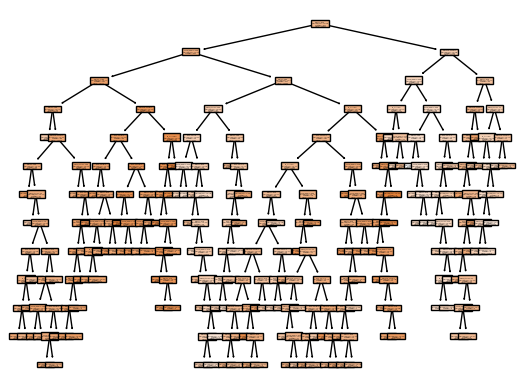

In [109]:
modelx = rfor.estimators_[99]
modelx1 = rfor.estimators_[2]
plt.figure(figsize=(200, 100))  # Adjust the size as needed
plot_tree(modelx, 
          filled=True, 
          feature_names=selected_fetures
          )  # Replace 'feature_names' with your actual feature names
plt.show()
plot_tree(modelx1, 
          filled=True, 
          feature_names=selected_fetures
          )  # Replace 'feature_names' with your actual feature names
plt.show()

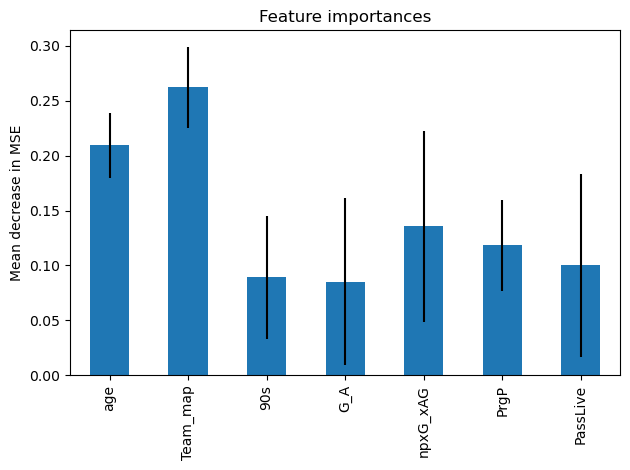

In [110]:
importances = rfor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfor.estimators_], axis=0)


forest_importances = pd.Series(importances, index=selected_fetures)

 
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in MSE")
fig.tight_layout()